<a href="https://colab.research.google.com/github/mrdbourke/tensorflow-deep-learning/blob/main/04_transfer_learning_in_tensorflow_part_1_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. Transfer Learning with TensorFlow Part 1: Feature Extraction

We've built a bunch of convolutional neural networks from scratch and they all seem to be learning, however, there is still plenty of room for improvement.

To improve our model(s), we could spend a while trying different configurations, adding more layers, changing the learning rate, adjusting the number of neurons per layer and more.

However, doing this is very time consuming.

Luckily, there's a technique we can use to save time.

It's called **transfer learning**, in other words, taking the patterns (also called weights) another model has learned from another problem and using them for our own problem.

There are two main benefits to using transfer learning:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has **already learned** patterns on similar data to our own. This often results in achieving great results with less custom data.

What this means is, instead of hand-crafting our own neural network architectures or building them from scratch, we can utilise models which have worked for others.

And instead of training our own models from scratch on our own datasets, we can take the patterns a model has learned from datasets such as [ImageNet](http://www.image-net.org/) (millions of images of different objects) and use them as the foundation of our own. Doing this often leads to getting great results with less data.

Over the next few notebooks, we'll see the power of transfer learning in action.

## What we're going to cover

We're going to go through the following with TensorFlow:

- Introduce transfer learning (a way to beat all of our old self-built models)
- Using a smaller dataset to experiment faster (10% of training samples of 10 classes of food)
- Build a transfer learning feature extraction model using TensorFlow Hub
- Introduce the TensorBoard callback to track model training results
- Compare model results using TensorBoard

## How you can use this notebook

You can read through the descriptions and the code (it should all run, except for the cells which error on purpose), but there's a better option.

Write all of the code yourself.

Yes. I'm serious. Create a new notebook, and rewrite each line by yourself. Investigate it, see if you can break it, why does it break?

You don't have to write the text descriptions but writing the code yourself is a great way to get hands-on experience.

Don't worry if you make mistakes, we all do. The way to get better and make less mistakes is to **write more code**.

In [1]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'
import tensorflow as tf
import tensorflow_hub as hub
import zipfile
import datetime
import matplotlib.pyplot as plt

2025-09-09 12:13:56.444038: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-09 12:13:56.557231: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-09 12:13:56.590816: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-09 12:13:56.784776: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Add timestamp
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

Notebook last run (end-to-end): 2025-09-09 12:14:01.469511


## Using a GPU

To begin, let's check to see if we're using a GPU. Using a GPU will make sure our model trains faster than using just a CPU.


In [3]:
# Are we using a GPU?
!nvidia-smi

Tue Sep  9 12:14:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.64.01              Driver Version: 576.88         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1660 ...    On  |   00000000:01:00.0  On |                  N/A |
| 53%   39C    P8             23W /  125W |    1213MiB /   6144MiB |     17%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

If the cell above doesn't output something which looks like:

```
Fri Sep  4 03:35:21 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU   GI   CI        PID   Type   Process name                  GPU Memory |
|        ID   ID                                                   Usage      |
|=============================================================================|
|  No running processes found                                                 |
+-----------------------------------------------------------------------------+
```

Go to Runtime -> Change Runtime Type -> Hardware Accelerator and select "GPU", then rerun the cell above.

## Transfer leanring with TensorFlow Hub: Getting great results with 10% of the data

If you've been thinking, "surely someone else has spent the time crafting the right model for the job..." then you're in luck. 

For many of the problems you'll want to use deep learning for, chances are, a working model already exists.

And the good news is, you can access many of them on TensorFlow Hub.

[TensorFlow Hub](https://tfhub.dev/) is a repository for existing model components. It makes it so you can import and use a fully trained model with as little as a URL.

Now, I really want to demonstrate the power of transfer learning to you.

To do so, what if I told you we could get much of the same results (or better) than our best model has gotten so far with only 10% of the original data, in other words, 10x less data.

This seems counterintuitive right?

Wouldn't you think more examples of what a picture of food looked like led to better results?

And you'd be right if you thought so, generally, more data leads to better results.

However, what if you didn't have more data? What if instead of 750 images per class, you had 75 images per class?

Collecting 675 more images of a certain class could take a long time.

So this is where another major benefit of transfer learning comes in.

**Transfer learning often allows you to get great results with less data.**

But don't just take my word for it. Let's download a subset of the data we've been using, namely 10% of the training data from the `10_food_classes` dataset and use it to train a food image classifier on.

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/04-transfer-learning-feature-extraction.png)
*What we're working towards building. Taking a pre-trained model and adding our own custom layers on top, extracting all of the underlying patterns learned on another dataset our own images.*



# --- 1. SETUP DE DADOS ---

In [4]:
# Download e extração dos dados
if not os.path.exists("10_food_classes_10_percent.zip"):
  !curl --output 10_food_classes_10_percent.zip --url https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
  zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
  zip_ref.extractall()
  zip_ref.close()

# Verificação dos diretórios
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  160M  100  160M    0     0  11.9M      0  0:00:13  0:00:13 --:--:-- 14.0M
There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There 

In [5]:
# Verificação dos diretórios
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent

Notice how each of the training directories now has 75 images rather than 750 images. This is key to demonstrating how well transfer learning can perform with less labelled images.

The test directories still have the same amount of images. This means we'll be training on less data but evaluating our models on the same amount of test data.

# # --- 2. PREPARAÇÃO DOS DADOS ---

Now we've downloaded the data, let's use the [`ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) class along with the `flow_from_directory` method to load in our images.

In [6]:
# Definição de constantes
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

# Removido: A seção inteira do ImageDataGenerator foi substituída.
# NOVO: Usando a API moderna para carregar dados
print("Carregando imagens de treino...")
train_data = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    image_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE
)

print("Carregando imagens de teste...")
test_data = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    image_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE
)

# O número de classes é obtido a partir dos nomes das classes do dataset
num_classes = len(train_data.class_names)
print(f"Encontradas {num_classes} classes: {train_data.class_names}")

Carregando imagens de treino...
Found 750 files belonging to 10 classes.


I0000 00:00:1757430857.062125   61196 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1757430857.152260   61196 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1757430857.152355   61196 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1757430857.154450   61196 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1757430857.154501   61196 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Carregando imagens de teste...
Found 2500 files belonging to 10 classes.
Encontradas 10 classes: ['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon', 'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi']


# --- 3. CRIAÇÃO DO MODELO ---

In [7]:
# Callback do TensorBoard
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = os.path.join(dir_name, experiment_name, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

# URLs do TensorFlow Hub
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

def create_model(model_url, num_classes=10):
  """
  Cria um modelo Keras usando a API Funcional, que é mais flexível.
  """
  # 1. Defina a camada de input
  inputs = tf.keras.Input(shape=IMAGE_SHAPE+(3,), name="input_layer")
  
  # 2. Adicione a camada de normalização
  x = tf.keras.layers.Rescaling(1./255)(inputs)
  
  # 3. Adicione a camada do TensorFlow Hub
  feature_extractor_layer = hub.KerasLayer(
      model_url,
      trainable=False,
      name='feature_extraction_layer'
  )
  x = feature_extractor_layer(x) # Conecte a camada do Hub
  
  # 4. Adicione a camada de saída
  outputs = tf.keras.layers.Dense(num_classes, activation='softmax', name='output_layer')(x)
  
  # 5. Crie o modelo Keras juntando as entradas e saídas
  model = tf.keras.Model(inputs, outputs)
  
  return model

# --- 4. TREINAMENTO DO MODELO RESNET ---

In [8]:
# Criar e compilar o modelo ResNet
print("\n--- Treinando ResNet50V2 ---")
resnet_model = create_model(resnet_url, num_classes=num_classes)
resnet_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

# Treinar o modelo
# MUDANÇA: steps_per_epoch e validation_steps não são mais necessários com tf.data.Dataset
resnet_history = resnet_model.fit(
    train_data,
    epochs=5,
    validation_data=test_data,
    callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", experiment_name="resnet50V2")]
)


--- Treinando ResNet50V2 ---
Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20250909-121421
Epoch 1/5


23/24 [===========================>..] - ETA: 0s - loss: 1.9672 - accuracy: 0.3438

24/24 [==============================] - ETA: 0s - loss: 1.9513 - accuracy: 0.3480

24/24 [==============================] - 20s 565ms/step - loss: 1.9513 - accuracy: 0.3480 - val_loss: 1.2024 - val_accuracy: 0.6064
Epoch 2/5


24/24 [==============================] - 10s 426ms/step - loss: 0.9197 - accuracy: 0.7213 - val_loss: 0.8579 - val_accuracy: 0.7244
Epoch 3/5
24/24 [==============================] - 10s 432ms/step - loss: 0.6477 - accuracy: 0.8080 - val_loss: 0.7379 - val_accuracy: 0.7668
Epoch 4/5
24/24 [==============================] - 10s 429ms/step - loss: 0.4784 - accuracy: 0.8707 - val_loss: 0.7001 - val_accuracy: 0.7788
Epoch 5/5
24/24 [==============================] - 10s 436ms/step - loss: 0.3776 - accuracy: 0.9240 - val_loss: 0.6583 - val_accuracy: 0.7892


# --- 5. PLOT E SUMÁRIO ---


Curvas de Perda e Acurácia do ResNet:


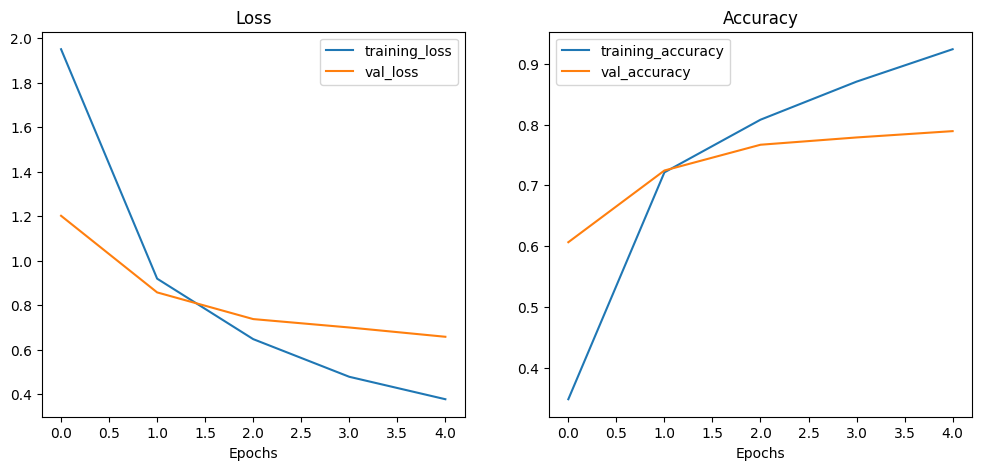

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [9]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  epochs = range(len(history.history['loss']))

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()
  plt.show()

print("\nCurvas de Perda e Acurácia do ResNet:")
plot_loss_curves(resnet_history)
resnet_model.summary()

# --- 6. TREINAMENTO DO MODELO EFFICIENTNET ---


--- Treinando EfficientNetB0 ---
Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20250909-121529
Epoch 1/5


23/24 [===========================>..] - ETA: 0s - loss: 1.9057 - accuracy: 0.4117

24/24 [==============================] - ETA: 0s - loss: 1.8958 - accuracy: 0.4173

24/24 [==============================] - 23s 453ms/step - loss: 1.8958 - accuracy: 0.4173 - val_loss: 1.3185 - val_accuracy: 0.7360
Epoch 2/5


24/24 [==============================] - 8s 318ms/step - loss: 1.0656 - accuracy: 0.7853 - val_loss: 0.8709 - val_accuracy: 0.8184
Epoch 3/5
24/24 [==============================] - 8s 324ms/step - loss: 0.7556 - accuracy: 0.8333 - val_loss: 0.6957 - val_accuracy: 0.8472
Epoch 4/5
24/24 [==============================] - 8s 319ms/step - loss: 0.6079 - accuracy: 0.8640 - val_loss: 0.6091 - val_accuracy: 0.8532
Epoch 5/5
24/24 [==============================] - 8s 320ms/step - loss: 0.5171 - accuracy: 0.8827 - val_loss: 0.5569 - val_accuracy: 0.8612

Curvas de Perda e Acurácia do EfficientNet:


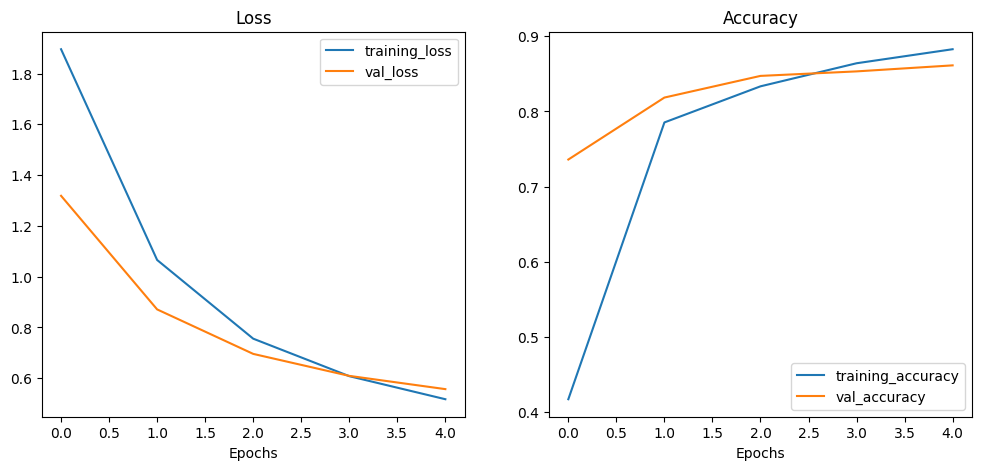

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [10]:
# Criar e compilar o modelo EfficientNet
print("\n--- Treinando EfficientNetB0 ---")
efficientnet_model = create_model(model_url=efficientnet_url, num_classes=num_classes)
efficientnet_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

# Treinar o modelo
# MUDANÇA: steps_per_epoch e validation_steps não são mais necessários com tf.data.Dataset
efficientnet_history = efficientnet_model.fit(
    train_data,
    epochs=5,
    validation_data=test_data,
    callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", experiment_name="efficientnetB0")]
)

print("\nCurvas de Perda e Acurácia do EfficientNet:")
plot_loss_curves(efficientnet_history)
efficientnet_model.summary()

In [11]:
!rm -r __MACOSX/
!rm -r 10_food_classes_10_percent/
!rm 10_food_classes_10_percent.zip

Excellent! Loading in the data we can see we've got 750 images in the training dataset belonging to 10 classes (75 per class) and 2500 images in the test set belonging to 10 classes (250 per class).